In [1]:
#!/opt/conda/envs/lae2020/bin/python3

from importlib.abc import Loader
import sys
import os
import ruamel.yaml

sys.path.insert(0,"/home/chinahg/GCresearch/cantera/build/python")
sys.path.insert(1,"/home/chinahg/GCresearch/rocketemissions")

import cantera as ct
ct.add_directory('/user/chinahg')
ct.__file__

import h5py
import numpy as np
import time
import math as math
import matplotlib.pyplot as plt
import scipy as sp
import scipy.optimize
import yaml
import shutil
from scipy import integrate
import matplotlib.pyplot as plt
import Analytical_Plume_fxns as ap

In [ ]:
D = 2.90 # [m] initial plume diameter
U_a = 428 #ambient velocity [m/s] (need to import)
P_atm = 101325 # ambient pressure [Pa] ##NEED TO IMPORT
T0 = 1800 # [K] ##NEED TO IMPORT

# Use reaction mechanism GRI-Mech 3.0. For 0-D simulations,
# no transport model is necessary.
gas = ct.Solution('A2NOx.yaml')

# Create a Reservoir for the inlet, set to a methane/air mixture at a specified
# equivalence ratio
equiv_ratio = 0.5  # lean combustion
gas.TP = 300.0, ct.one_atm
gas.set_equivalence_ratio(equiv_ratio, 'H2:1.0', 'O2:1.0, N2:3.76')
inlet = ct.Reservoir(gas)

# Create the combustor, and fill it initially with a mixture consisting of the
# equilibrium products of the inlet mixture. This state corresponds to the state
# the reactor would reach with infinite residence time, and thus provides a good
# initial condition from which to reach a steady-state solution on the reacting
# branch.
gas.equilibrate('HP')
combustor = ct.IdealGasReactor(gas)
combustor.volume = 1.0

# Create a reservoir for the exhaust
exhaust = ct.Reservoir(gas)

# Use a variable mass flow rate to keep the residence time in the reactor
# constant (residence_time = mass / mass_flow_rate). The mass flow rate function
# can access variables defined in the calling scope, including state variables
# of the Reactor object (combustor) itself.


def mdot(t):
    return combustor.mass / residence_time


inlet_mfc = ct.MassFlowController(inlet, combustor, mdot=mdot)

# A PressureController has a baseline mass flow rate matching the 'master'
# MassFlowController, with an additional pressure-dependent term. By explicitly
# including the upstream mass flow rate, the pressure is kept constant without
# needing to use a large value for 'K', which can introduce undesired stiffness.
outlet_mfc = ct.PressureController(combustor, exhaust, master=inlet_mfc, K=0.01)

# the simulation only contains one reactor
sim = ct.ReactorNet([combustor])

# Run a loop over decreasing residence times, until the reactor is extinguished,
# saving the state after each iteration.
states = ct.SolutionArray(gas, extra=['tres'])

residence_time = 0.1  # starting residence time
while combustor.T > 500:
    sim.set_initial_time(0.0)  # reset the integrator
    sim.advance_to_steady_state()
    states.append(combustor.thermo.state, tres=residence_time)
    residence_time *= 0.9  # decrease the residence time for the next iteration

# Plot results
f, ax1 = plt.subplots(1, 1)
ax1.plot(states.tres, states.heat_release_rate, '.-', color='C0')
ax2 = ax1.twinx()
ax2.plot(states.tres[:-1], states.T[:-1], '.-', color='C1')
ax1.set_xlabel('residence time [s]')
ax1.set_ylabel('heat release rate [W/m$^3$]', color='C0')
ax2.set_ylabel('temperature [K]', color='C1')
f.tight_layout()
plt.show()

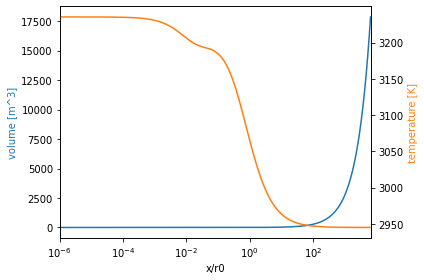

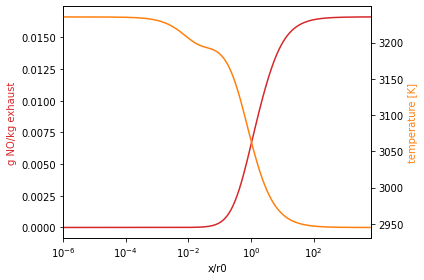

In [50]:
P_CC0 = 101325
mdot_f = 500 #exhaust mdot [kg/s] #NEED TO IMPORT
U0 = 4625 #NEED TO IMPORT
mdot_ox = 0.068*U0
r0 = 1.45

#WSR
#Create Gas Mixture
gasExhaust = ct.Solution('A2NOx.yaml')
gasExhaust.TPY = 1845, P_CC0, 'O2: 6, H2:1'
gasExhaust.equilibrate('HP')

gasFuel = ct.Solution('A2NOx.yaml') #ct.Hydrogen()
gasFuel.TPX = 1845, 101325, 'H2:1, O2:1' #https://science.ksc.nasa.gov/shuttle/technology/sts-newsref/et.html#:~:text=LIQUID%20HYDROGEN%20TANK,-The%20liquid%20hydrogen&text=Its%20operating%20pressure%20range%20is,to%20the%20left%20aft%20umbilical.
gasOx = ct.Solution('A2NOx.yaml') #ct.Oxygen()
gasOx.TPX = 298, 101325, 'N2:1'

#Create Reactor Infrastructure
tankFuel = ct.Reservoir(gasFuel)
tankOx = ct.Reservoir(gasOx)
CC_exhaust1 = ct.Reservoir(gasExhaust)

CC_reactor = ct.IdealGasConstPressureReactor(gasExhaust) #create CC with random gas initially filling it

#Connect tanks to CC
flow_controller_fuel = ct.MassFlowController(upstream=tankFuel,downstream=CC_reactor,mdot=mdot_f)
flow_controller_ox = ct.MassFlowController(upstream=tankOx,downstream=CC_reactor,mdot=mdot_ox)

#Connect CC to exhaust reservoir
CC_reactorNet = ct.ReactorNet([CC_reactor])

#React!
t = 0
state = ct.SolutionArray(gasOx, extra=['t','volume','enthalpy','eox','efuel'])
while t < 2:
    CC_reactorNet.step()
    t = CC_reactorNet.time
    #CC_reactorNet.advance(t)
    
    # Extract the state of the reactor
    state.append(CC_reactor.thermo.state, volume=CC_reactor.volume, t=t, enthalpy=gasExhaust.enthalpy_mole, efuel=gasFuel.enthalpy_mole, eox=gasOx.enthalpy_mole)

# Plot results
f, ax1 = plt.subplots(1, 1)
ax1.plot(state.t*U0/r0, state.volume, color='C0')
ax2 = ax1.twinx()
ax1.set_xlim(0.000001,)
ax2.plot(state.t[:-1]*U0/r0, state.T[:-1], color='C1')
ax1.set_xlabel('x/r0')
ax1.set_ylabel('volume [m^3]', color='C0')
ax2.set_ylabel('temperature [K]', color='C1')
ax1.set_xscale('log')
f.tight_layout()
plt.show()

f, ax1 = plt.subplots(1, 1)
ax1.plot(state.t*U0/r0, state.Y[:,11]*mdot_f, color='C3')
ax2 = ax1.twinx()
ax1.set_xlim(0.000001,)
ax2.plot(state.t[:-1]*U0/r0, state.T[:-1], color='C1')
ax1.set_xlabel('x/r0')
ax1.set_ylabel('g NO/kg exhaust', color='C3')
ax2.set_ylabel('temperature [K]', color='C1')
ax1.set_xscale('log')
f.tight_layout()
plt.show()